In [2]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [3]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)
    
def age_model(x1,x2,x3):  
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
    p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
    age = (p[0]+p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
           p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
           p[10]*(x2**3)+p[11]*(x3**3))
    
    return age
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [4]:
################
### LMC Data ###
################

### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

gcs = fits.getdata('allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = gcs[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### PARSEC
# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

# rgb = np.where(parsecall['label']==3)
# parsec = parsecall[rgb]

# linAge: 0.5e9 - 7.0e9, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
young_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_0.5_7.0.dat',format='basic',
                          delimiter='\s')
# linAge: 7.5e9 - 1.4e10, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
old_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_7.5_14.0.dat',format='basic',
                          delimiter='\s')

parsec = vstack([young_parsec,old_parsec])

rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

### GC cluster tables
'''
The ACS survey of Galactic globular clusters – XIV. Bayesian single-population analysis of 69 globular clusters
Wagner-Kaiser et al. 2017
'''
import pandas as pd
supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp3 = pd.read_csv('../stx544_Supp/Table3.txt',comment='#',
                    names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',
                           'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',
                           'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',
                           'RelativeAge'],sep='\s+')

-2.1930616

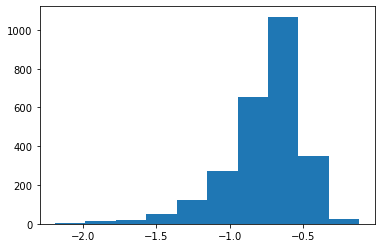

In [12]:
plt.hist(lmc['FE_H'])
min(lmc['FE_H'])

In [4]:
ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['Cluster'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M3: NGC5272
    elif (gcs['Cluster'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['Cluster'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['Cluster'][i]=='M5'): 
        ngc_names.append('NGC5904')
    
    #M10: NGC6254
    elif (gcs['Cluster'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M12: NGC6218
    elif (gcs['Cluster'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['Cluster'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15: NGC7078
    elif (gcs['Cluster'][i]=='M15'): 
        ngc_names.append('NGC7078')
    
    #M19: NGC6273
    elif (gcs['Cluster'][i]=='M19'): 
        ngc_names.append('NGC6273')
    
    #M22: NGC6656
    elif (gcs['Cluster'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M53: NGC5024
    elif (gcs['Cluster'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M54: NGC6715
    elif (gcs['Cluster'][i]=='M54'): 
        ngc_names.append('NGC6715')
    
    #M55: NGC6809
    elif (gcs['Cluster'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68: NGC4590
    elif (gcs['Cluster'][i]=='M68'): 
        ngc_names.append('NGC4590')   
    
    #M71: NGC6838
    elif (gcs['Cluster'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['Cluster'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92: NGC6341
    elif (gcs['Cluster'][i]=='M92'): 
        ngc_names.append('NGC5904')
    
    #M107: NGC6171
    elif (gcs['Cluster'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #omegaCen: NGC5139
    elif (gcs['Cluster'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['Cluster'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

In [5]:
apogee_clus_idx = []

for i in supp2['Cluster'][s2_ind]:
    apogee_clus_idx.append(np.where(ngc_names==i))

In [6]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

In [7]:
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

_,_, ldist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])

lmc_ksmag = absmag(lmc['K'],ldist)
gcs_ksmag = absmag(gcs['K'],gcs['distmed'])

In [8]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = gcs['distmed'][i]
    dist_err = gcs['sigma_dist'][i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = add_noise(dist,dist_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
#         am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
devs = np.asarray(devs)
parages = np.asarray(parages)

In [9]:
close_age = []
close_feh = []
for i in apogee_clus_idx:
    use_age = np.median(parages[i])
    use_feh = np.median(gcs['FE_H'][i])
    
    close_age.append(closest(use_age,parsec['logAge']))
    close_feh.append(closest(use_feh,parsec['MH']))
    
supp2_close_age = []
for j in supp2['Age'][s2_ind]:
    supp2_close_age.append(closest(np.log10(j*(10**9)),parsec['logAge']))

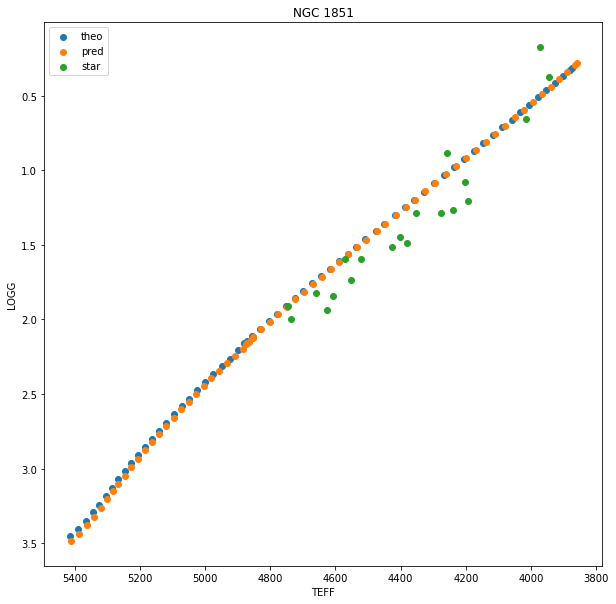

In [10]:
ngc1851 = np.where(ngc_names=='NGC1851') #stars in gcs

ngc1851p = np.where((parsec['logAge']==10.0)&(parsec['MH']==-1.1)) #parsec isochrone with age based on lit
ngc1851c = np.where((parsec['logAge']==10.0607)&(parsec['MH']==-1.1)) #parsec isochrone with age based on cal

plt.figure(figsize=[10,10])


plt.scatter(10**parsec['logTe'][ngc1851p],parsec['logg'][ngc1851p],label='theo')
plt.scatter(10**parsec['logTe'][ngc1851c],parsec['logg'][ngc1851c],label='pred')

plt.scatter(gcs['TEFF'][ngc1851],gcs['LOGG'][ngc1851],label='star')
plt.legend()
    
# plt.scatter(lmc['TEFF'],lmc['LOGG'])
    
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'NGC 1851')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')
plt.show()

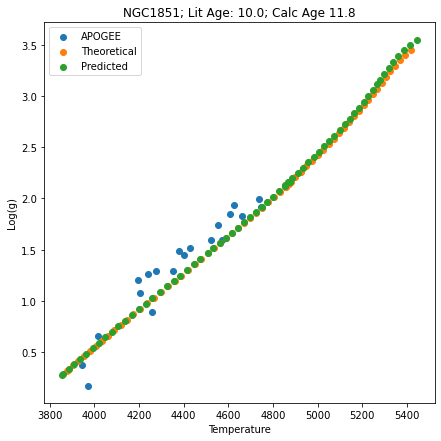

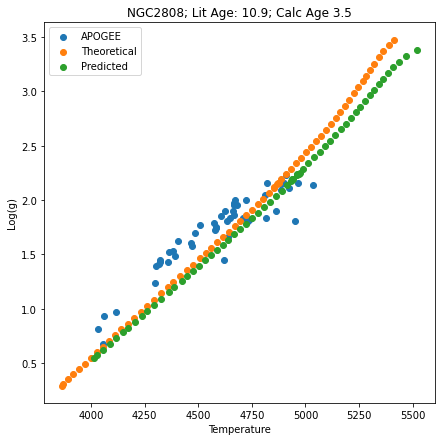

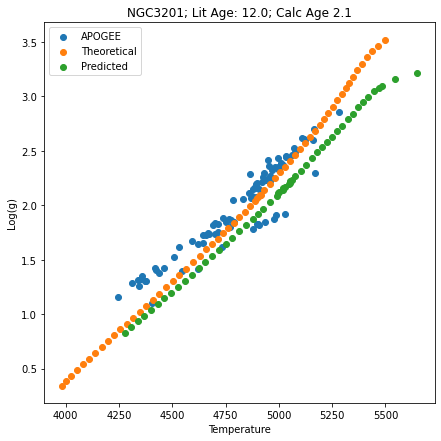

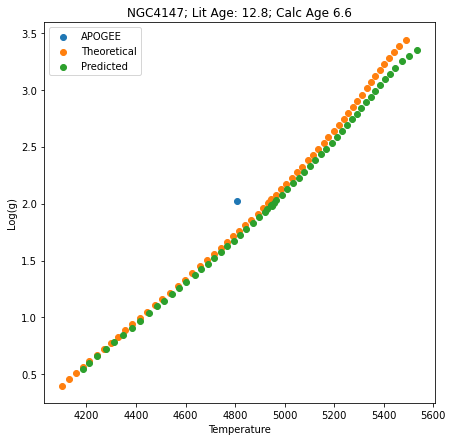

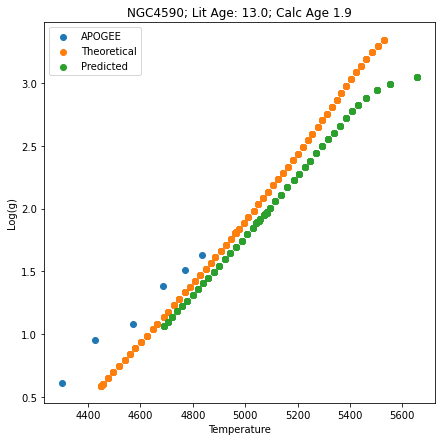

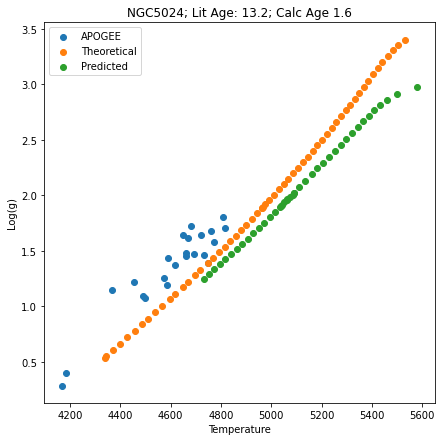

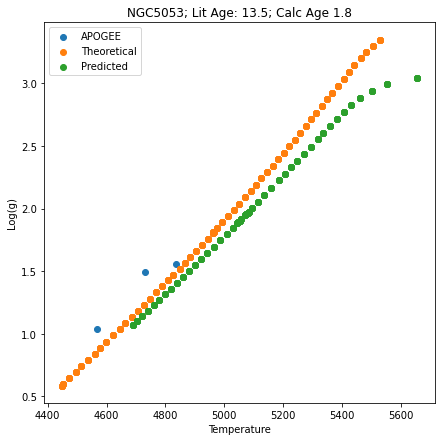

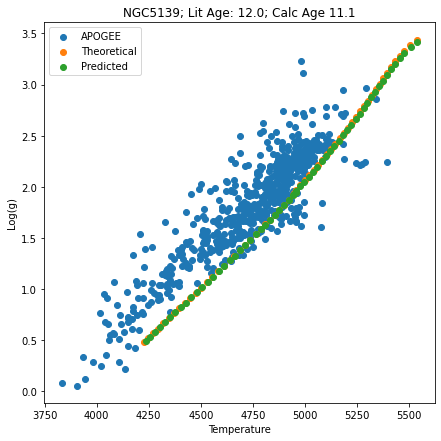

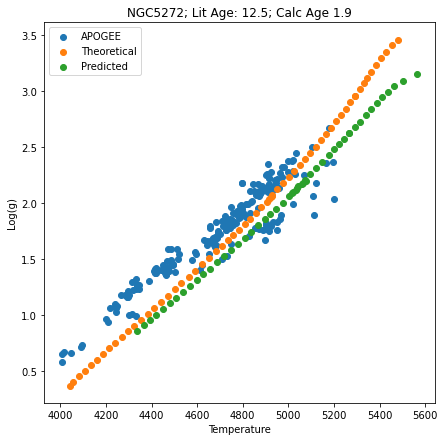

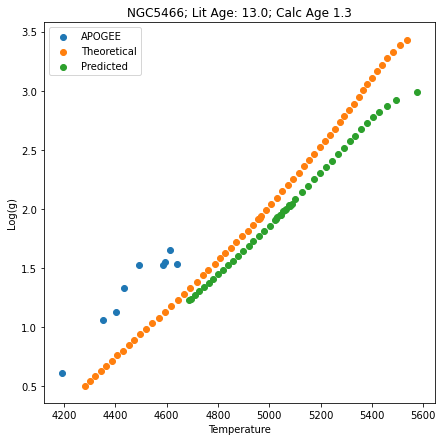

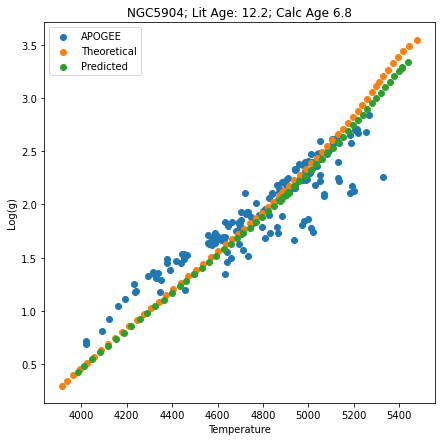

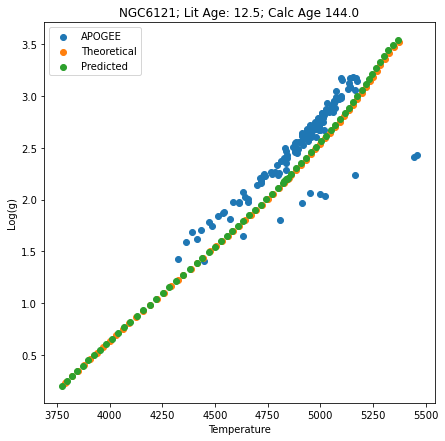

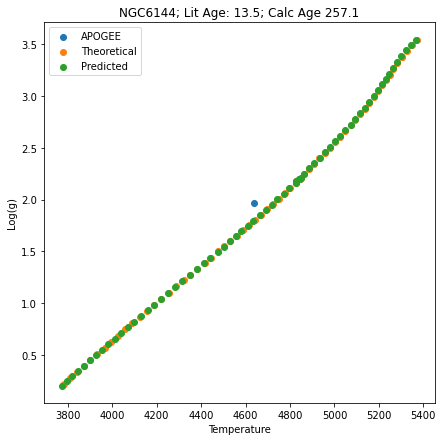

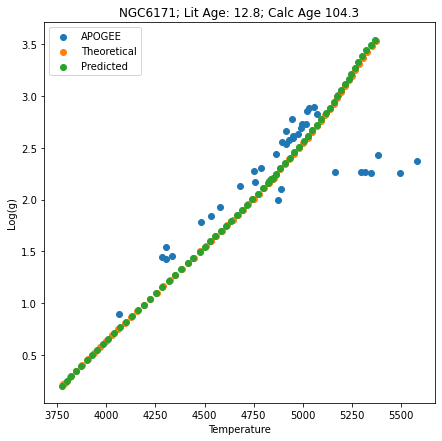

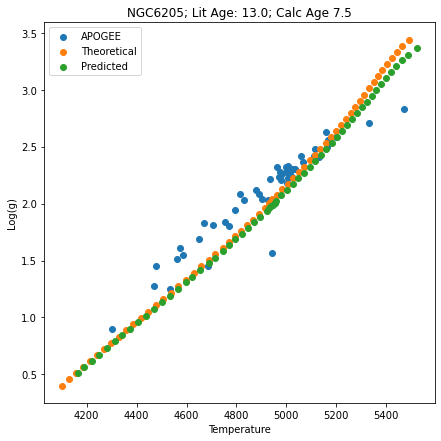

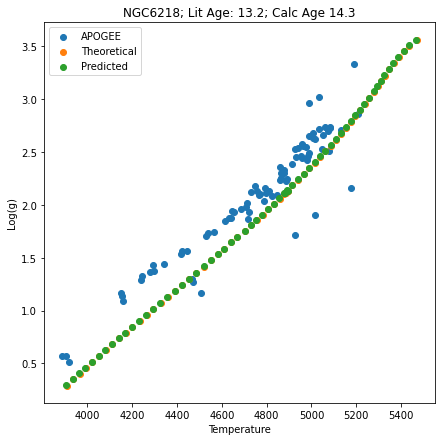

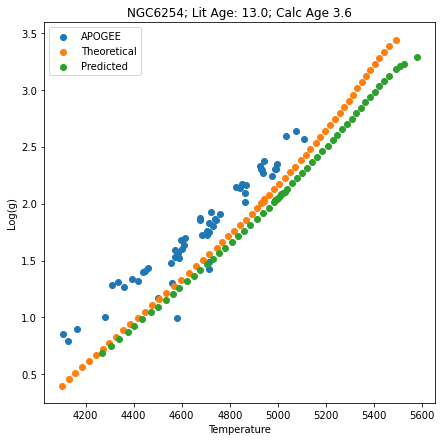

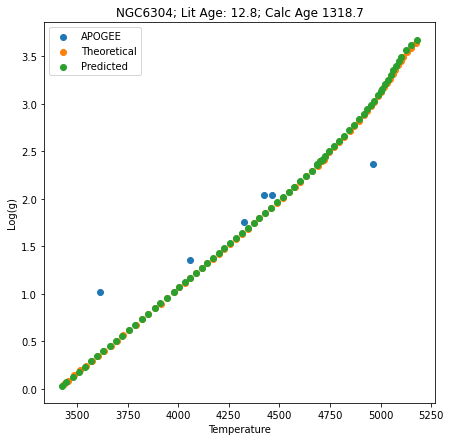

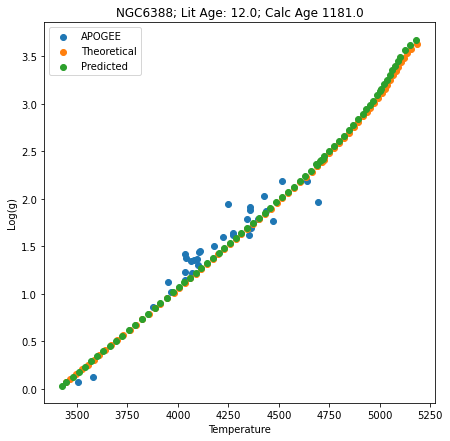

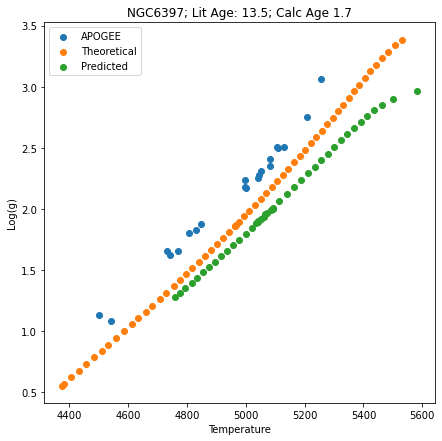

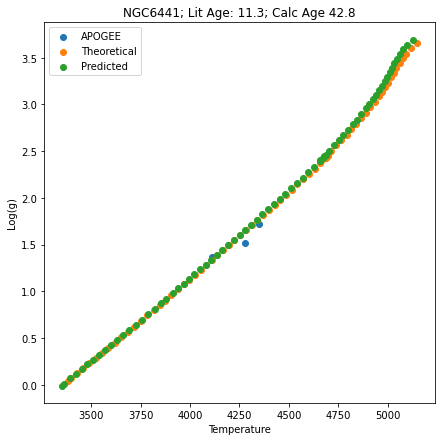

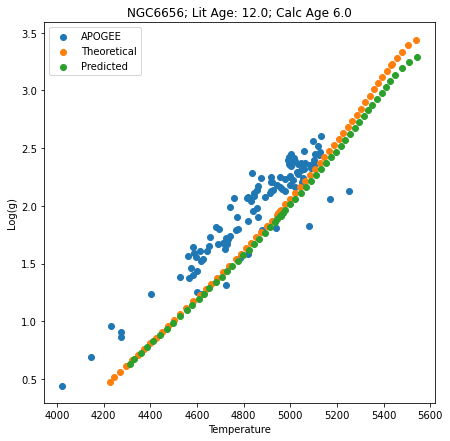

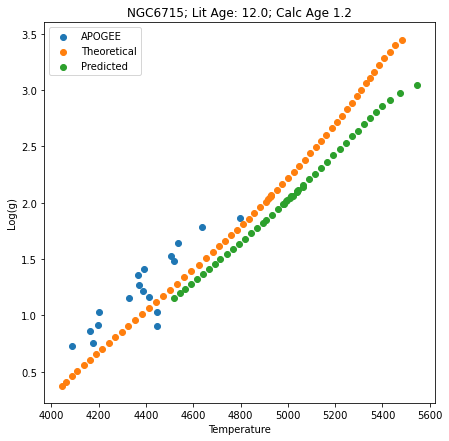

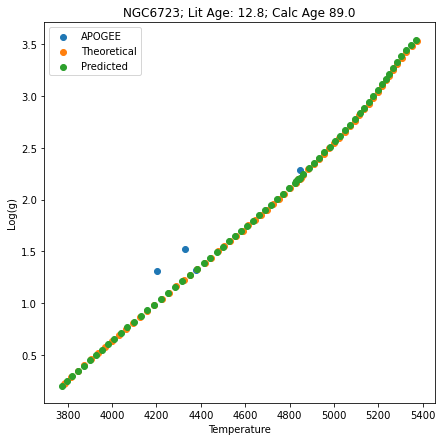

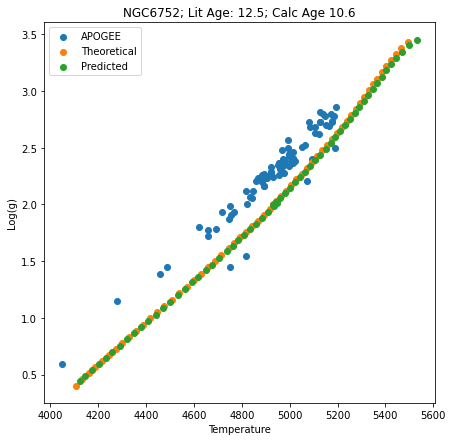

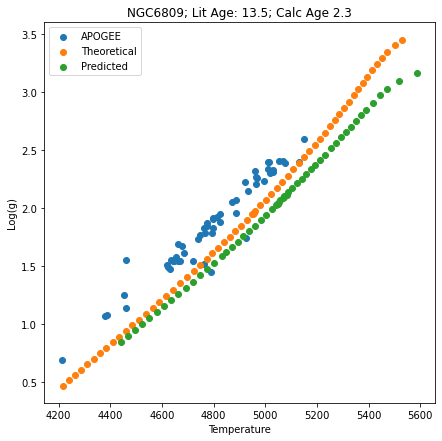

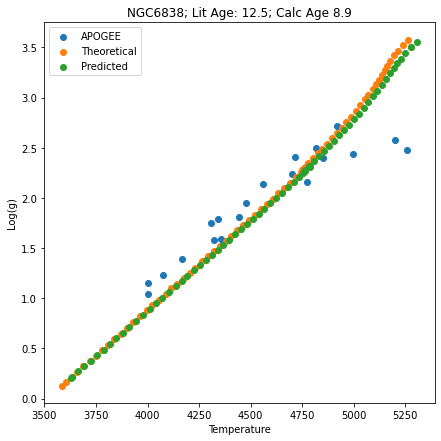

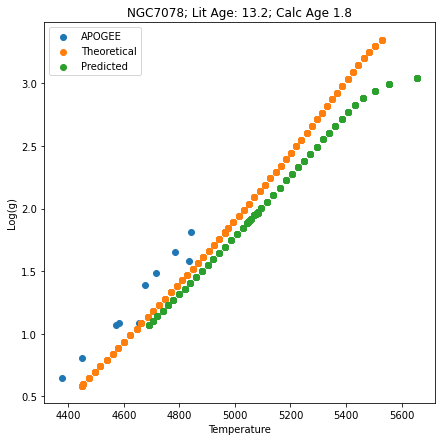

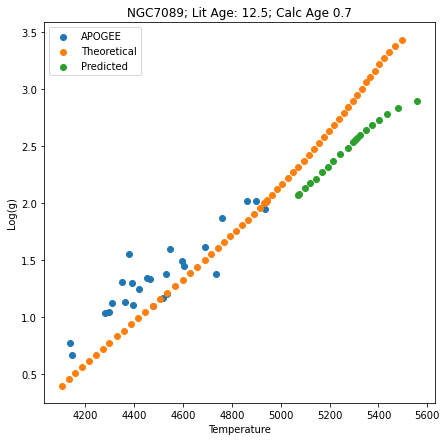

In [11]:
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
    pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
    
    plt.scatter(gcs['TEFF'][clus],gcs['LOGG'][clus],label='APOGEE')
    plt.scatter(10**parsec['logTe'][theo],parsec['logg'][theo],label='Theoretical')
    plt.scatter(10**parsec['logTe'][pred],parsec['logg'][pred],label='Predicted')
    
    plt.legend()
    
    plt.title(r'{}; Lit Age: {:.1f}; Calc Age {:.1f}'.format(np.asarray(supp2['Cluster'])[s2_ind][i],
                                                         np.asarray(supp2['Age'])[s2_ind][i],
                                                         10**np.median(parages[clus])/10**9))
    plt.xlabel(r'Temperature')
    plt.ylabel(r'Log(g)')
    plt.show()

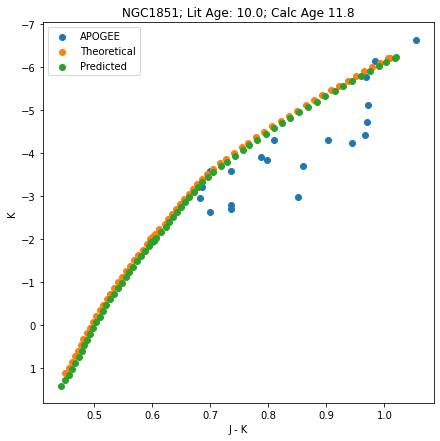

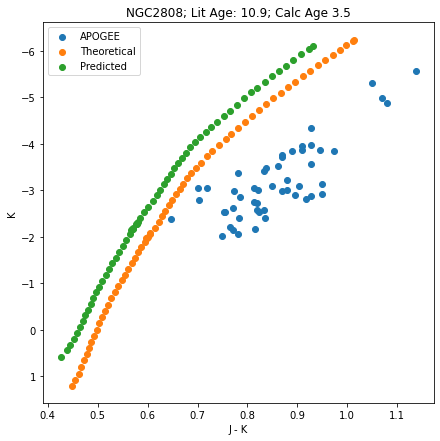

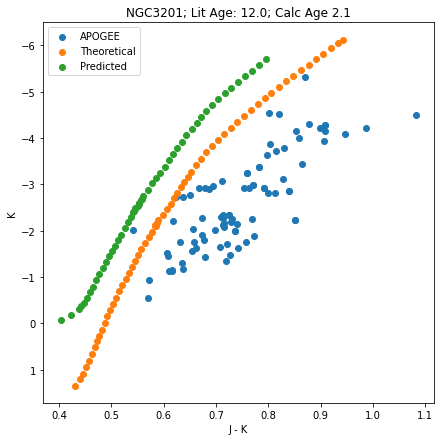

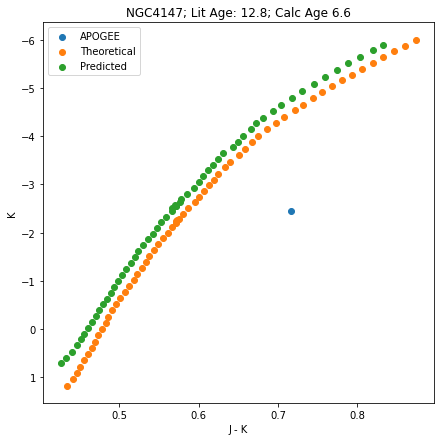

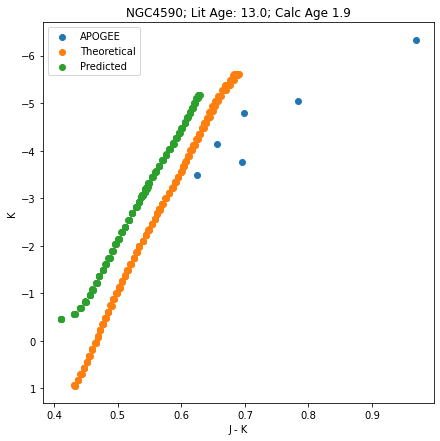

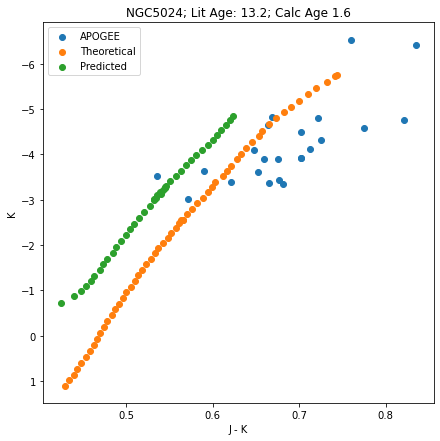

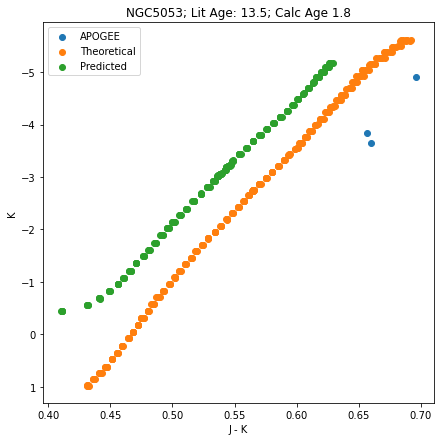

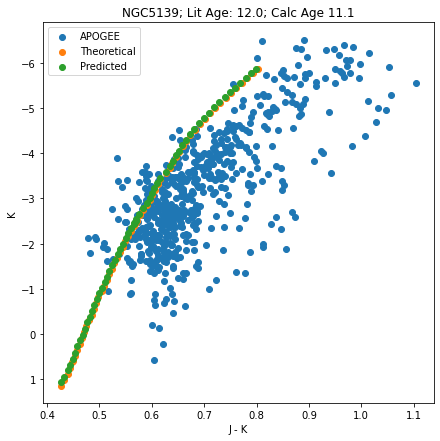

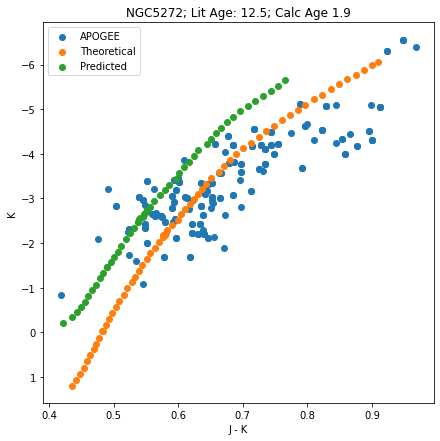

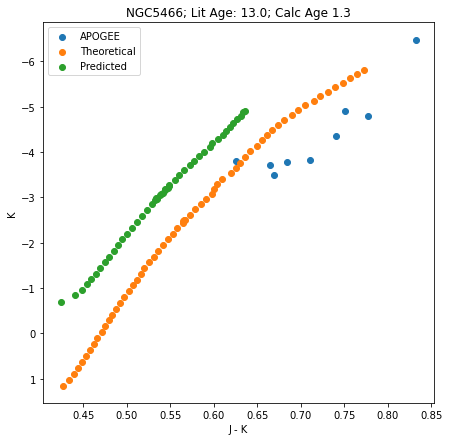

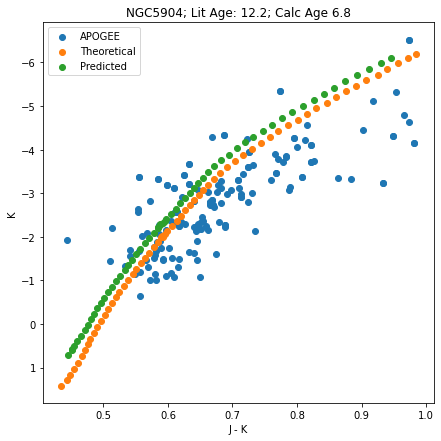

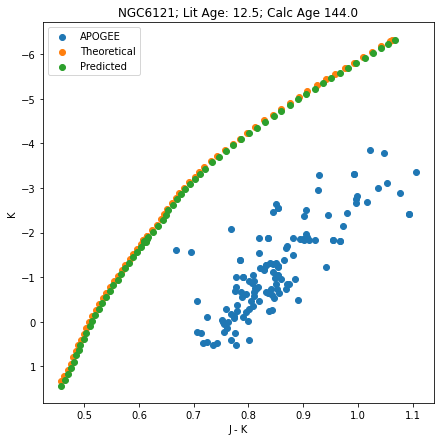

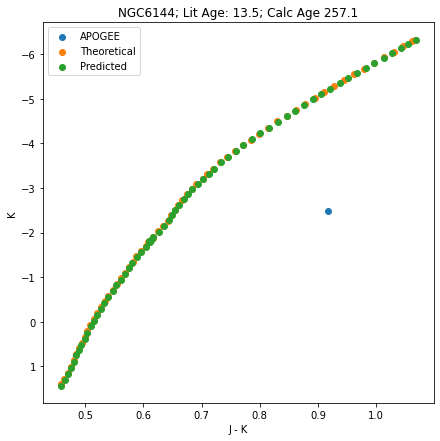

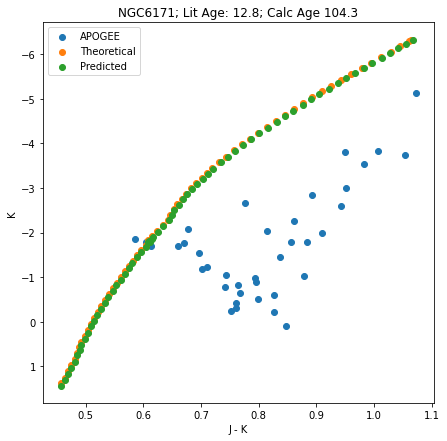

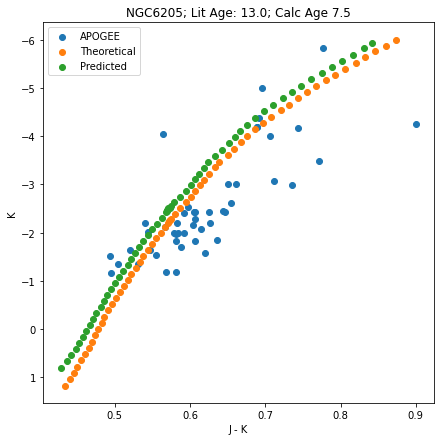

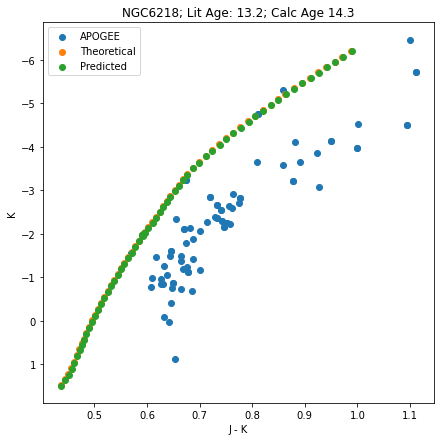

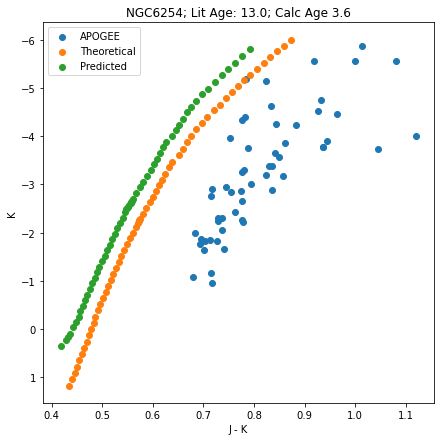

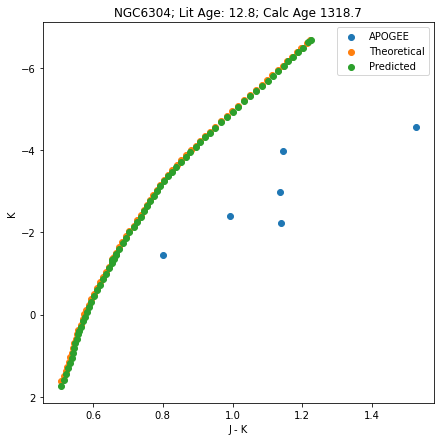

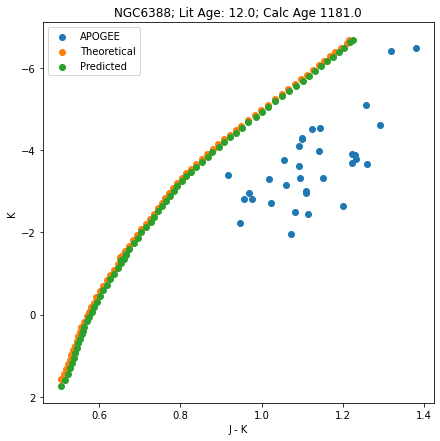

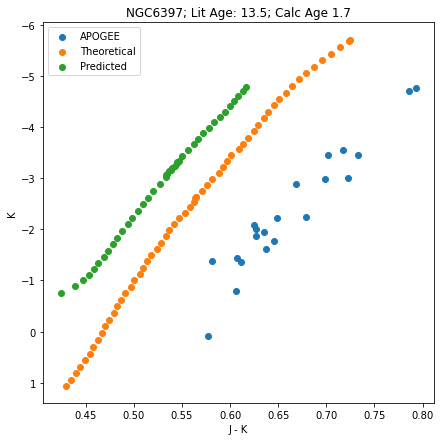

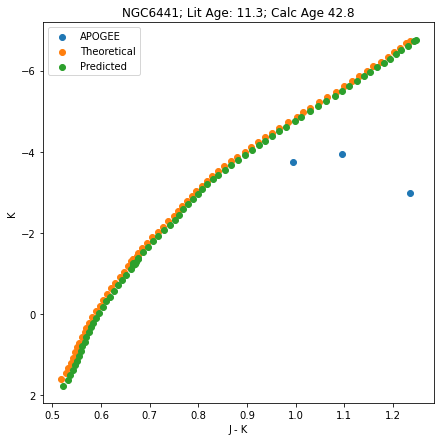

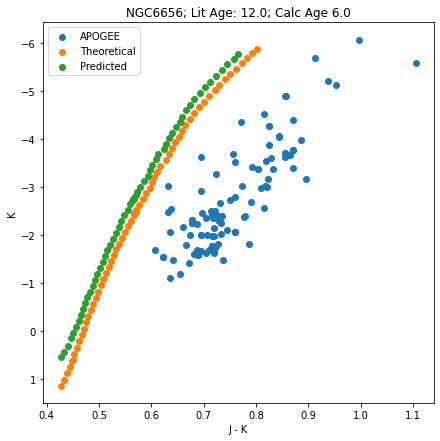

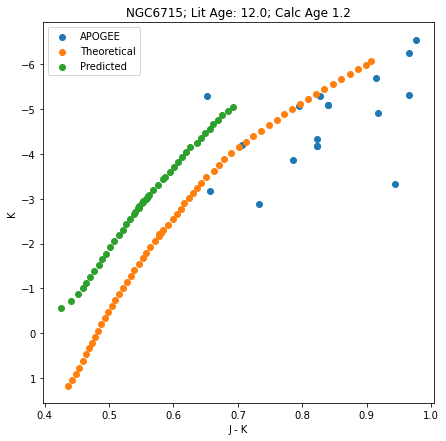

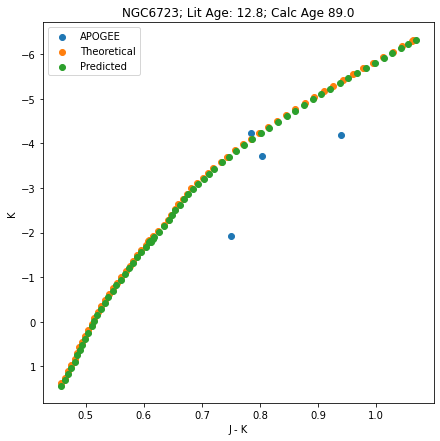

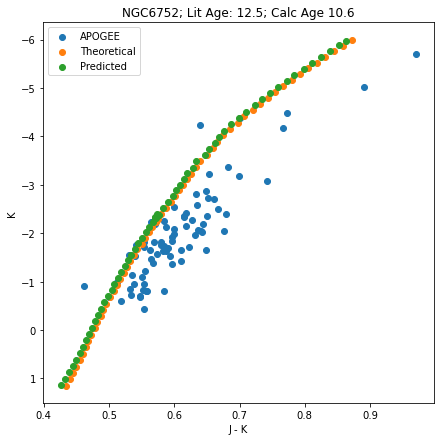

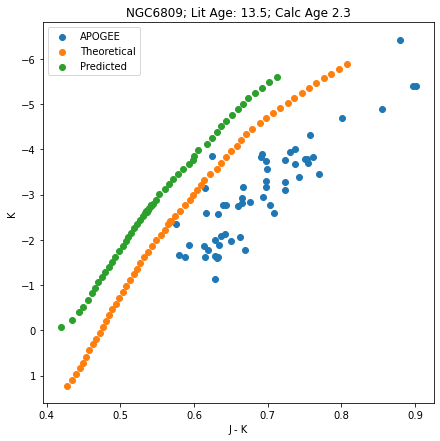

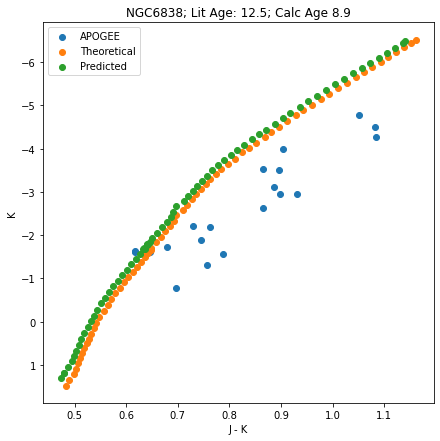

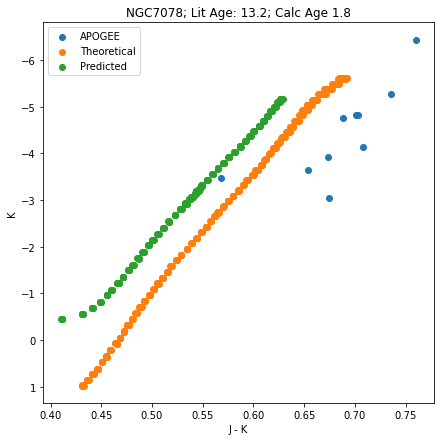

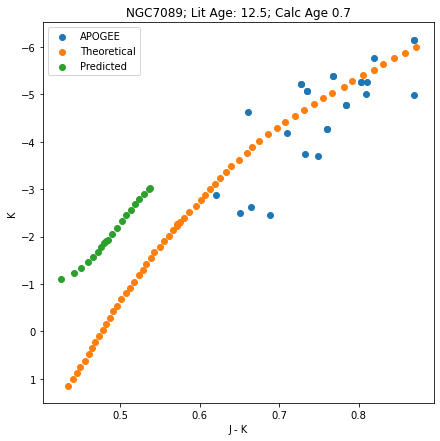

In [12]:
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
    pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
    
    plt.scatter((gcs['J']-gcs['K'])[clus],gcs_ksmag[clus],label='APOGEE')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[theo],parsec['Ksmag'][theo],label='Theoretical')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[pred],parsec['Ksmag'][pred],label='Predicted')
    
    plt.legend()
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}; Lit Age: {:.1f}; Calc Age {:.1f}'.format(np.asarray(supp2['Cluster'])[s2_ind][i],
                                                         np.asarray(supp2['Age'])[s2_ind][i],
                                                         10**np.median(parages[clus])/10**9))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

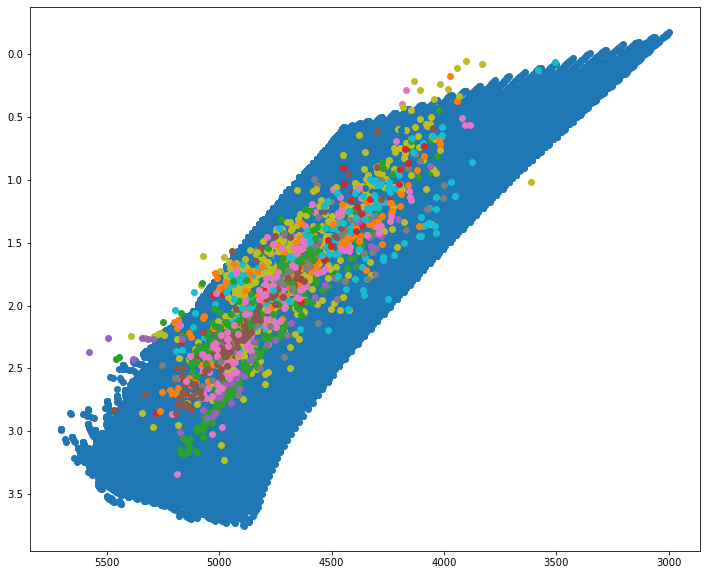

In [44]:
plt.figure(figsize=[12,10])

plt.scatter(10**parsec['logTe'],parsec['logg'])

for i in apogee_clus_idx:
    plt.scatter(gcs['TEFF'][i],gcs['LOGG'][i])
    
# plt.scatter(lmc['TEFF'],lmc['LOGG'])
    
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [48]:
np.unique(supp2['Age'][s2_ind])

array([10.  , 10.9 , 11.3 , 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 ])

In [56]:
np.where(supp2['Cluster'] == np.asarray(supp2['Cluster'][s2_ind])[0])

supp2['Age'][7]

10.0

In [60]:
np.asarray(supp2['Cluster'][s2_ind])[0]

'NGC1851'

In [19]:
len(np.unique(supp2['Cluster'][s2_ind]))

29

In [67]:
np.median(parages[ngc1851])
np.median(parages)

10.068328368315733

In [68]:
np.unique(parsec['logAge'])

8.69897
9.0
9.17609
9.30103
9.39794
9.47712
9.54407
9.60206
9.65321
9.69897
9.74036


In [86]:
supp2['Cluster'][s2_ind]

7     NGC1851
9     NGC2808
10    NGC3201
11    NGC4147
12    NGC4590
14    NGC5024
15    NGC5053
16    NGC5139
17    NGC5272
19    NGC5466
20    NGC5904
25    NGC6121
26    NGC6144
27    NGC6171
28    NGC6205
29    NGC6218
30    NGC6254
31    NGC6304
36    NGC6388
37    NGC6397
39    NGC6441
47    NGC6656
49    NGC6715
51    NGC6723
52    NGC6752
54    NGC6809
55    NGC6838
59    NGC7078
60    NGC7089
Name: Cluster, dtype: object

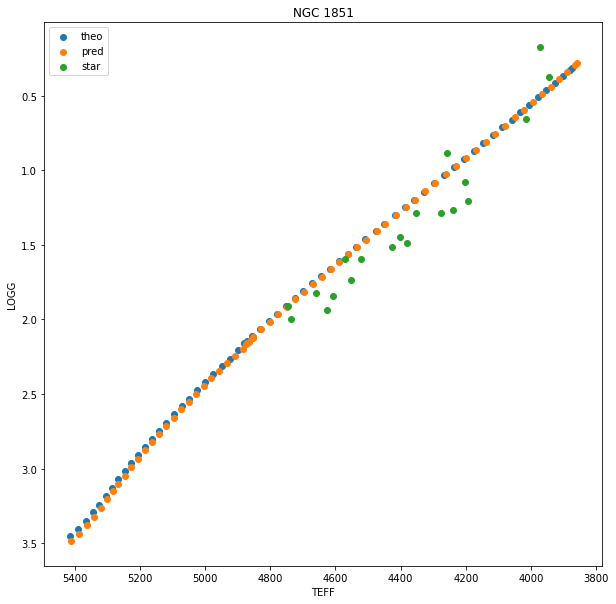

In [74]:
ngc1851 = np.where(ngc_names=='NGC1851') #stars in gcs

ngc1851p = np.where((parsec['logAge']==10.0)&(parsec['MH']==-1.1)) #parsec isochrone with age based on lit
ngc1851c = np.where((parsec['logAge']==10.0607)&(parsec['MH']==-1.1)) #parsec isochrone with age based on cal

plt.figure(figsize=[10,10])


plt.scatter(10**parsec['logTe'][ngc1851p],parsec['logg'][ngc1851p],label='theo')
plt.scatter(10**parsec['logTe'][ngc1851c],parsec['logg'][ngc1851c],label='pred')

plt.scatter(gcs['TEFF'][ngc1851],gcs['LOGG'][ngc1851],label='star')
plt.legend()
    
# plt.scatter(lmc['TEFF'],lmc['LOGG'])
    
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'NGC 1851')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')
plt.show()

In [78]:
ngc1851 = np.where(ngc_names=='NGC1851') #stars in gcs

ngc1851p = np.where((parsec['logAge']==10.0)&(parsec['MH']==-1.1)) #parsec isochrone with age based on lit
ngc1851c = np.where((parsec['logAge']==10.0607)&(parsec['MH']==-1.1)) #parsec isochrone with age based on cal

plt.figure(figsize=[10,10])


plt.scatter(10**parsec['logTe'][ngc1851p],parsec['logg'][ngc1851p],label='theo')
plt.scatter(10**parsec['logTe'][ngc1851c],parsec['logg'][ngc1851c],label='pred')

plt.scatter(gcs['TEFF'][ngc1851],gcs['LOGG'][ngc1851],label='star')
plt.legend()
    
# plt.scatter(lmc['TEFF'],lmc['LOGG'])
    
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'NGC 1851')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')
plt.show()

5

In [79]:
def closest(val,dat):
    '''
    find index of value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return abs_diff.argmin()

In [ ]:
lit_close = [] 
for i in range():